## **0. Introduction**

This notebook follows after the "General Linear Model.iypnb" notebook. Aim of this notebook is to conduct the support vector machine. For now, we have 26 z-maps, so one for each contrast, for each session, i.e. 4 * 26 z-maps. We will train the SVM on two sessions and then test the SVM on the remaining two sessions.

## **1. Masking**

First we will need to load the mask. The masks needs to be fetched from the openneuro dataset. This is done with *datalad*.

We cd into the local dataset directory and then use the command:

datalad get sourcedata/sub-01/anat.

The masks are bi-lateral organised, meaning one mask per hemisphere. For starters, the higher visual cortex (HVC) will be the first mask.

In [1]:
import os

os.chdir("/home/jpauli/ds001506/sourcedata/sub-01/anat")
os.listdir()

['sub-01_mask_LH_FFA.nii.gz',
 'sub-01_mask_LH_hV4.nii.gz',
 'sub-01_mask_LH_HVC.nii.gz',
 'sub-01_mask_LH_LOC.nii.gz',
 'sub-01_mask_LH_PPA.nii.gz',
 'sub-01_mask_LH_V1d.nii.gz',
 'sub-01_mask_LH_V1v.nii.gz',
 'sub-01_mask_LH_V2d.nii.gz',
 'sub-01_mask_LH_V2v.nii.gz',
 'sub-01_mask_LH_V3d.nii.gz',
 'sub-01_mask_LH_V3v.nii.gz',
 'sub-01_mask_RH_FFA.nii.gz',
 'sub-01_mask_RH_hV4.nii.gz',
 'sub-01_mask_RH_HVC.nii.gz',
 'sub-01_mask_RH_LOC.nii.gz',
 'sub-01_mask_RH_PPA.nii.gz',
 'sub-01_mask_RH_V1d.nii.gz',
 'sub-01_mask_RH_V1v.nii.gz',
 'sub-01_mask_RH_V2d.nii.gz',
 'sub-01_mask_RH_V2v.nii.gz',
 'sub-01_mask_RH_V3d.nii.gz',
 'sub-01_mask_RH_V3v.nii.gz']

In [2]:
len(os.listdir())

22

We can see that there are 22 masks in total, 11 for each hemisphere. 

In [125]:
mask_img_path = '/home/jpauli/ds001506/sourcedata/sub-01/anat'
mask_img_L = os.path.join(mask_img_path,'sub-01_mask_LH_V1v.nii.gz')
mask_img_R = os.path.join(mask_img_path,'sub-01_mask_RH_V1v.nii.gz')

In [4]:
func_filename_path = '/mnt/c/Users/janos/git/sessions_new/z_maps_3'
func_filename =  os.path.join(func_filename_path,'03_active -1443537.0_z_map.nii.gz')
#os.chdir('/mnt/c/Users/janos/git/sessions/z_maps_2')

/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/numpy/ma/core.py:2830: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


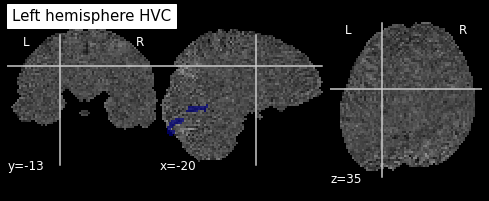

In [126]:
coordinates_func = (-20,-13,35)
from nilearn.plotting import plot_roi
plot_roi(mask_img_L, func_filename,display_mode='ortho',cut_coords=coordinates_func,
         title="Left hemisphere HVC")

Now the next step is to load in the X and Y variables. We will do this by applying Nilearns Niftimasker function on the z_maps we calculated.

Note: We set standardize to *True*, because we want our algorithm to have the best learning behavior. This i

In [127]:
from nilearn.maskers import NiftiMasker
nifti_masker = NiftiMasker(mask_img=mask_img_L)

This loops helps us in extracting the time series from each z-map.
Also, we append values to the Y list. We have 26 different categories we want to decode. Since there are 4 sessions in total and the categories are the same for each session, we will add a "1" for category one and so on to the Y list.

In [128]:
X = []
Y = []
Sessions = []
category = 1
for session in ["1","2","3","4"]:
    os.chdir('/mnt/c/Users/janos/git/sessions_new/z_maps_{}'.format(session))
    for x in os.listdir():
        if x == 'nilearn_cache':
            continue
        else:
            X.append(nifti_masker.fit_transform(x))
            Y.append(category)
            Sessions.append(session)
            category=category+1
            if category == 27:
                category = 1
        
            
        
        
        



In [129]:
import numpy as np
Y = np.array(Y)
Y.shape
Y

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       26,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26])

In [130]:
import pandas as pd
df =  pd.DataFrame(np.concatenate(X))

In [346]:
X_ = df.to_numpy()
X_.shape

(104, 992)

In [351]:
X_1 = np.reshape(X_[0],(31,32))
X_11 = np.reshape(X_[25],(31,32))
X_2 = np.reshape(X_[1],(31,32))
X_3 = np.reshape(X_[2],(31,32))
X_4 = np.reshape(X_[3],(31,32))

Text(0.5, 1.0, 'Voxel pattern category four')

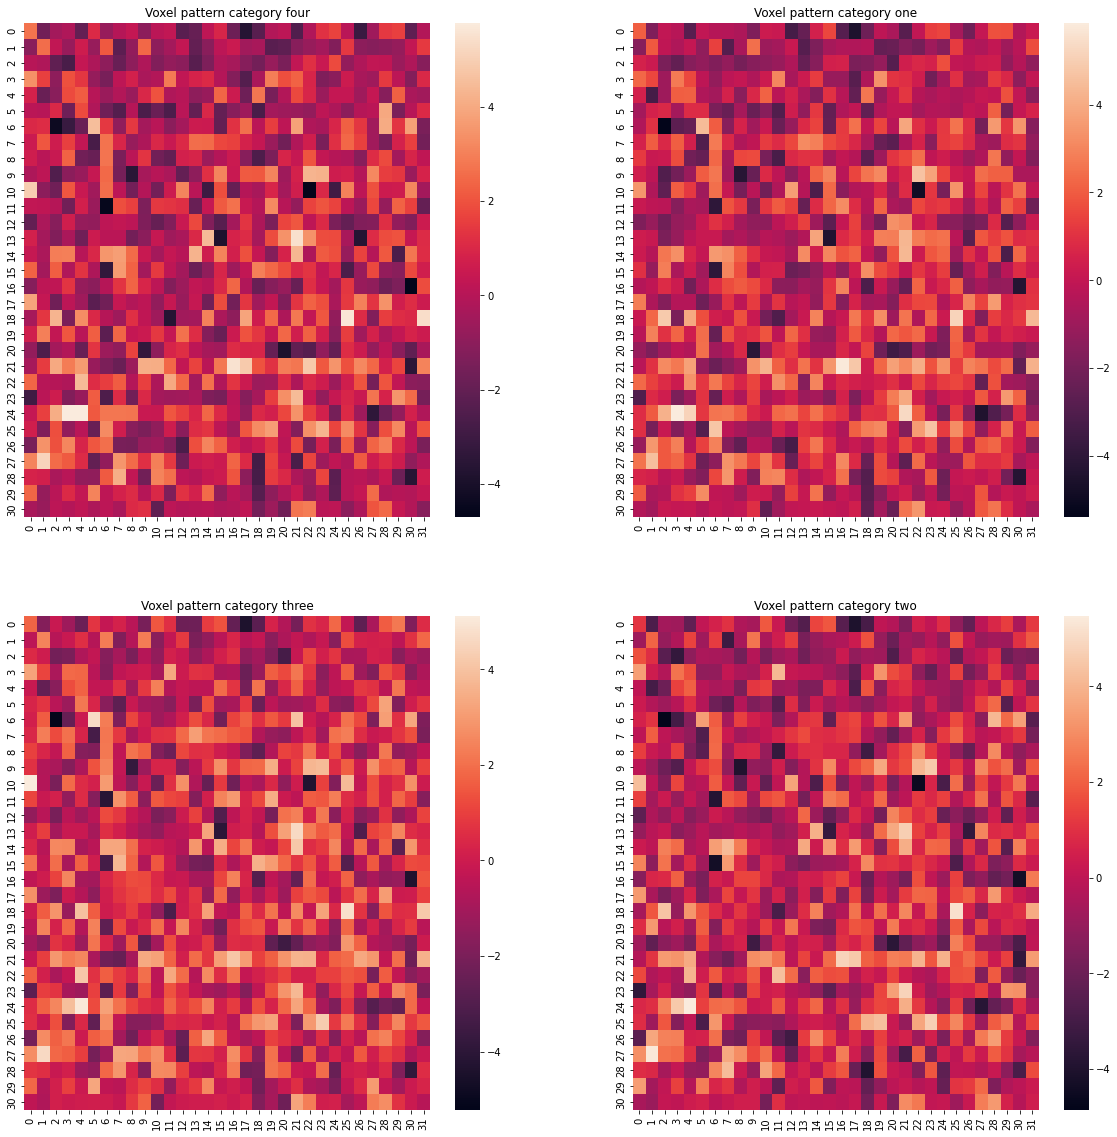

In [356]:
import seaborn as sns
figure, axis = plt.subplots(2, 2,figsize=(20, 20))
sns.heatmap(data=X_1, ax = axis[0,1])
sns.heatmap(data = X_2, ax = axis[1,1])
sns.heatmap(X_3, ax = axis[1,0])
sns.heatmap(X_4, ax = axis[0,0])

axis[0, 1].set_title("Voxel pattern category one")
axis[1, 1].set_title("Voxel pattern category two")
axis[1, 0].set_title("Voxel pattern category three")
axis[0, 0].set_title("Voxel pattern category four")

Text(0.5, 1.0, 'Voxel pattern category four')

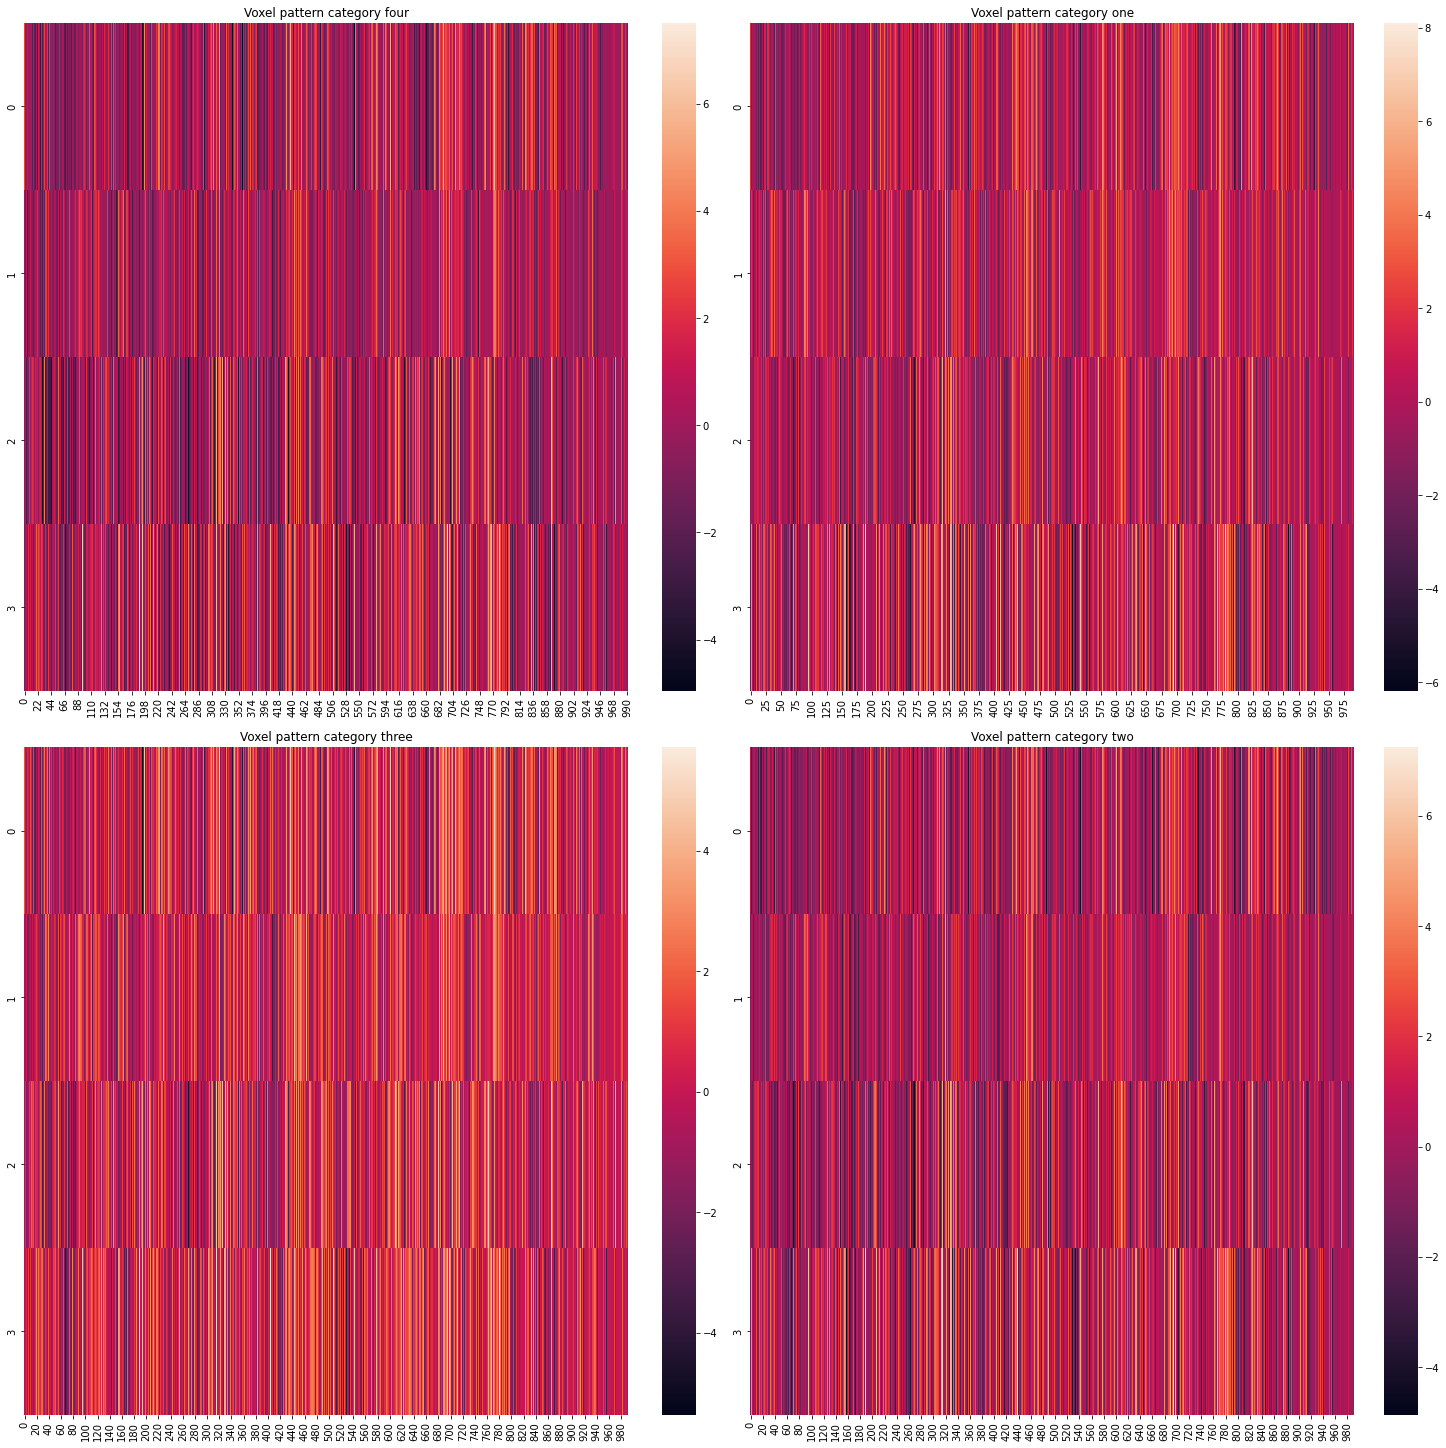

In [342]:
import seaborn as sns
figure, axis = plt.subplots(2, 2,figsize=(20, 20), constrained_layout = True)
sns.heatmap(data=X_1, ax = axis[0,1])
sns.heatmap(data = X_[[1,27,53,79]], ax = axis[1,1])
sns.heatmap(X_[[2,28,54,80]], ax = axis[1,0])
sns.heatmap(X_[[3,29,55,81]], ax = axis[0,0])

axis[0, 1].set_title("Voxel pattern category one")
axis[1, 1].set_title("Voxel pattern category two")
axis[1, 0].set_title("Voxel pattern category three")
axis[0, 0].set_title("Voxel pattern category four")

Text(0.5, 0, 'Voxel')

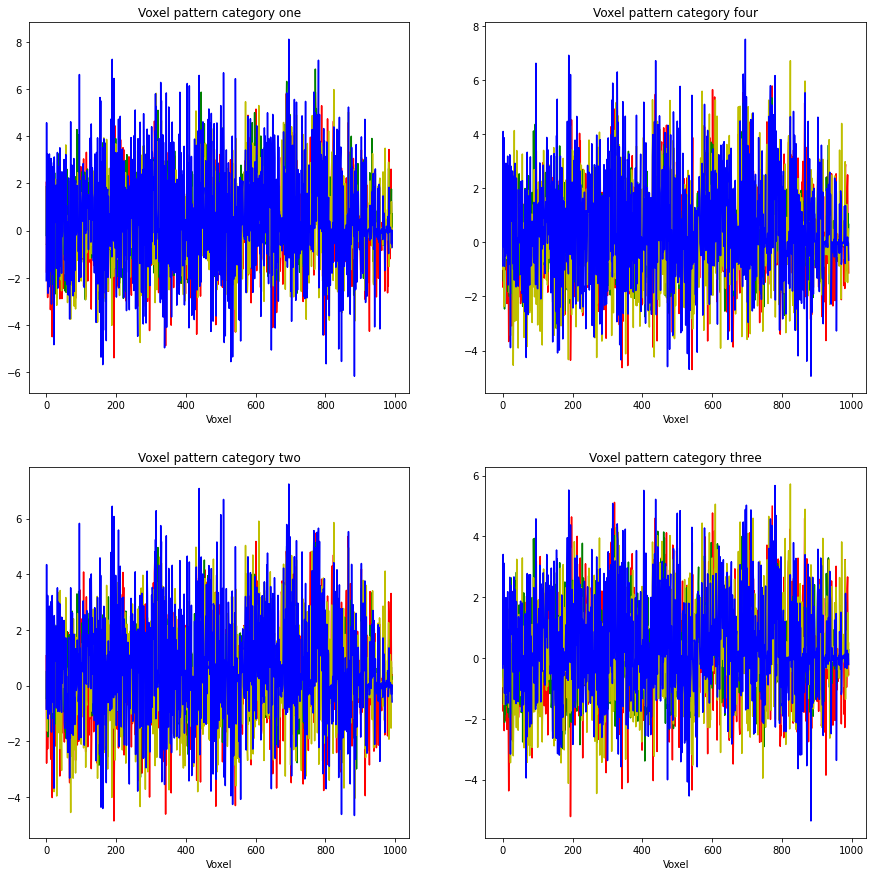

In [309]:

figure, axis = plt.subplots(2, 2,figsize=(15, 15))
axis[0,0].plot(X_[0],color='r',label='cat one');
axis[0,0].plot(X_[26], color = 'g')
axis[0,0].plot(X_[52], color = 'y')
axis[0,0].plot(X_[78], color = 'b')
axis[0, 0].set_title("Voxel pattern category one")

axis[1,0].plot(X_[1],color='r');
axis[1,0].plot(X_[27], color = 'g')
axis[1,0].plot(X_[53], color = 'y')
axis[1,0].plot(X_[79], color = 'b')
axis[1, 0].set_title("Voxel pattern category two")

axis[1,1].plot(X_[2],color='r');
axis[1,1].plot(X_[28], color = 'g')
axis[1,1].plot(X_[54], color = 'y')
axis[1,1].plot(X_[80], color = 'b')
axis[1, 1].set_title("Voxel pattern category three")

axis[0,1].plot(X_[3],color='r');
axis[0,1].plot(X_[29], color = 'g')
axis[0,1].plot(X_[55], color = 'y')
axis[0,1].plot(X_[81], color = 'b')
axis[0,1].set_title("Voxel pattern category four")

axis[0,1].set_xlabel('Voxel')
axis[1,1].set_xlabel('Voxel')
axis[1,0].set_xlabel('Voxel')
axis[0,0].set_xlabel('Voxel')

The shape of our input array X tells us, that we have n_samples = 104 and n_features = 992.
The features relate to the amount of voxels extracted. The samples are the 26 categories multiplied by all 4 sessions.

We now want to test if there are correlations between the features. This can later on help with understanding, which features are more important than other.

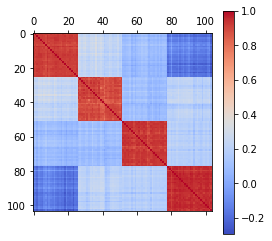

In [162]:
import matplotlib.pyplot as plt
corr =np.corrcoef(X_)
plt.matshow(corr, cmap='coolwarm')
plt.colorbar()

In [76]:
from sklearn.feature_selection import mutual_info_classif
mutual = mutual_info_classif(X_, Y)
mutual.shape

(992,)

In [12]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=1000):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 1000))
print("Thanks stackoverflow!")

Top Absolute Correlations
567  675    0.997108
566  674    0.996595
948  952    0.994417
929  948    0.993847
924  944    0.993622
              ...   
931  964    0.945023
791  839    0.945020
707  713    0.944997
926  961    0.944968
904  952    0.944966
Length: 1000, dtype: float64
Thanks stackoverflow!


We now use sklearns train_test_split function to seperate our X and Y variables into training and testing data. We set test_size to 0.3, so we use 70% of the data for training and 30% for testing.

In [253]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_, Y, test_size=0.1, random_state=42)


In [14]:
#from sklearn import preprocessing
#min_max_scaler = preprocessing.MinMaxScaler()
#X_train_minmax = min_max_scaler.fit_transform(X_train)
#X_train_minmax

array([[0.65640901, 0.64102066, 0.51101272, ..., 0.68908865, 0.50142863,
        0.67039956],
       [0.71778238, 0.87777667, 1.        , ..., 0.28355079, 0.29289447,
        0.2381069 ],
       [0.43365384, 0.47945211, 0.43776067, ..., 0.28552602, 0.33475756,
        0.33401211],
       ...,
       [0.97259149, 0.90753251, 0.89419794, ..., 0.15933623, 0.05955221,
        0.18268643],
       [0.69013068, 0.63716386, 0.53984103, ..., 0.82168159, 0.62013413,
        0.71704432],
       [0.90881466, 0.84975189, 0.81720699, ..., 0.10202706, 0.06054517,
        0.10374189]])

In [15]:
#from sklearn import preprocessing
#min_max_scaler = preprocessing.MinMaxScaler()
#X_test_minmax = min_max_scaler.fit_transform(X_test)
#X_test_minmax

In [243]:
X_train.shape

(23, 992)

In [17]:
y_train.shape

(93,)

In [18]:
X_train

array([[ 0.25697228,  0.35553605, -0.04449253, ...,  0.52926412,
         0.05056445,  0.3789438 ],
       [ 0.35026784,  0.7685068 ,  0.60999505, ...,  0.02652161,
        -0.00719893, -0.09718073],
       [-0.08164473,  0.0737139 , -0.14253711, ...,  0.02897029,
         0.00439703,  0.00844869],
       ...,
       [ 0.73761104,  0.82040958,  0.46838373, ..., -0.12746633,
        -0.07183408, -0.1582205 ],
       [ 0.30823364,  0.34880867, -0.00590713, ...,  0.69363867,
         0.08344554,  0.43031806],
       [ 0.6406619 ,  0.71962351,  0.36533479, ..., -0.19851211,
        -0.07155903, -0.24516954]])

We see that we will test our model on 72 rows of both X and Y values

In [250]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C = 10, penalty = 'l1',multi_class='ovr',solver ='liblinear')


In [251]:
model.fit(X_train,y_train)

LogisticRegression(C=10, multi_class='ovr', penalty='l1', solver='liblinear')

In [252]:
model.score(X_test, y_test)

0.0

In [72]:
model.classes_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])